In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

LOGS_DIR = Path('logs')
ANALYTICS_DIR = Path('analytics')
ANALYTICS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def find_evaluation_files(logs_dir=LOGS_DIR):
    csv_files = sorted(logs_dir.glob('*_evaluation_metrics.csv'))
    out = []
    for csv in csv_files:
        name = csv.stem.replace('_evaluation_metrics','')
        json_path = logs_dir / f"{name}_aggregate_metrics.json"
        out.append({'name': name, 'csv': csv, 'json': json_path if json_path.exists() else None})
    return out

files = find_evaluation_files()

In [3]:
def load_all(files):
    data = {}
    for f in files:
        try:
            df = pd.read_csv(f['csv'])
        except Exception as e:
            print('Failed to read', f['csv'], '->', e)
            continue
        agg = None
        if f['json'] and Path(f['json']).exists():
            try:
                with open(f['json'],'r') as fh:
                    agg = json.load(fh)
            except Exception as e:
                print('Failed to read json', f['json'], '->', e)
        data[f['name']] = {'per_episode': df, 'aggregate': agg}
    return data

data = load_all(files)
print('Loaded datasets:', list(data.keys()))
for k,v in data.items():
    print(k, '-> episodes:', len(v['per_episode']))

Loaded datasets: ['a2c_baseline_speedrunner', 'a2c_speedrunner', 'a2c_survivor', 'ppo_baseline_speedrunner', 'ppo_speedrunner', 'ppo_survivor']
a2c_baseline_speedrunner -> episodes: 20
a2c_speedrunner -> episodes: 20
a2c_survivor -> episodes: 20
ppo_baseline_speedrunner -> episodes: 20
ppo_speedrunner -> episodes: 20
ppo_survivor -> episodes: 20


In [4]:
summary_rows = []
for name, payload in data.items():
    df = payload['per_episode']
    agg = payload['aggregate'] or {}
    row = {
        'experiment': name,
        'n_episodes': len(df),
        'mean_reward': float(df['reward'].mean()) if 'reward' in df.columns else np.nan,
        'std_reward': float(df['reward'].std()) if 'reward' in df.columns else np.nan,
        'mean_length': float(df['length'].mean()) if 'length' in df.columns else np.nan,
        'mean_time_to_goal': float(df['time_to_goal'].mean()) if 'time_to_goal' in df.columns and not df['time_to_goal'].isnull().all() else np.nan,
        'success_rate': float(df['level_completed'].mean()) if 'level_completed' in df.columns else np.nan,
    }
    if agg:
        row.update({f'agg_{k}': v for k,v in agg.items()})
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values('experiment')
summary_df.to_csv(ANALYTICS_DIR / 'experiments_summary.csv', index=False)
summary_df

,experiment,n_episodes,mean_reward,std_reward,mean_length,mean_time_to_goal,success_rate,agg_mean_reward,agg_std_reward,agg_mean_length,agg_mean_inputs,agg_mean_time_to_goal,agg_total_deaths,agg_levels_completed,agg_mean_distance_traveled,agg_mean_unique_tiles,agg_mean_max_x_velocity,agg_mean_max_y_velocity,agg_mean_max_momentum
0,a2c_baseline_speedrunner,20,-48.7115,0.792480,389.85,NaN,0.0,-48.7115,0.792480,389.85,389.85,NaN,20,0,320.250220,260.10,22.869583,75.000000,78.703964
1,a2c_speedrunner,20,-48.7555,0.816053,398.95,NaN,0.0,-48.7555,0.816053,398.95,398.95,NaN,20,0,313.628039,262.40,22.869583,72.300000,75.670120
2,a2c_survivor,20,-61.2050,40.893514,292.75,NaN,0.0,-61.2050,40.893514,292.75,292.75,NaN,20,0,229.447306,191.20,15.799166,50.000000,52.255199
3,ppo_baseline_speedrunner,20,-48.5650,0.747040,418.10,NaN,0.0,-48.5650,0.747040,418.10,418.10,NaN,20,0,348.104134,281.55,24.283667,80.000000,83.420509
4,ppo_speedrunner,20,-49.2695,1.565078,3750.25,NaN,0.0,-49.2695,1.565078,3750.25,3750.25,NaN,5,0,581.829532,36.80,4.491000,20.699999,21.491001
5,ppo_survivor,20,23.6725,221.606642,963.30,NaN,0.0,23.6725,221.606642,963.30,963.30,NaN,17,0,511.255413,247.30,18.627331,48.000000,53.037800


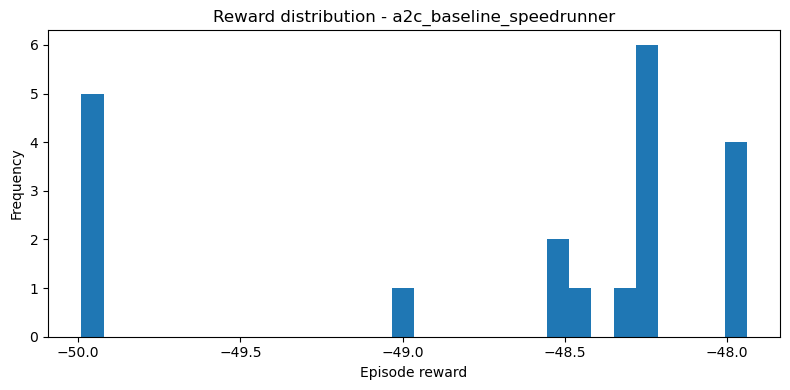

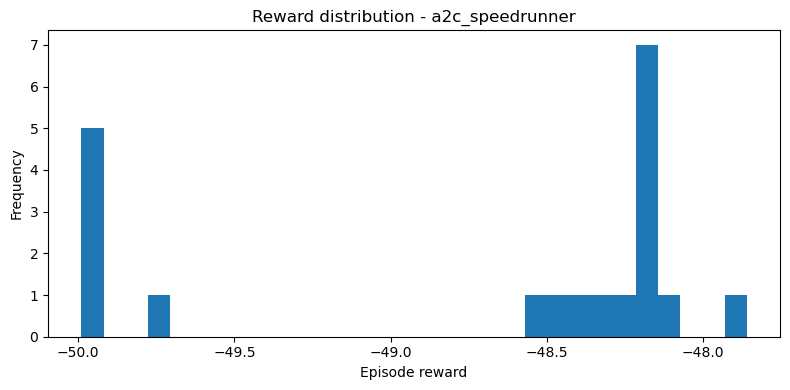

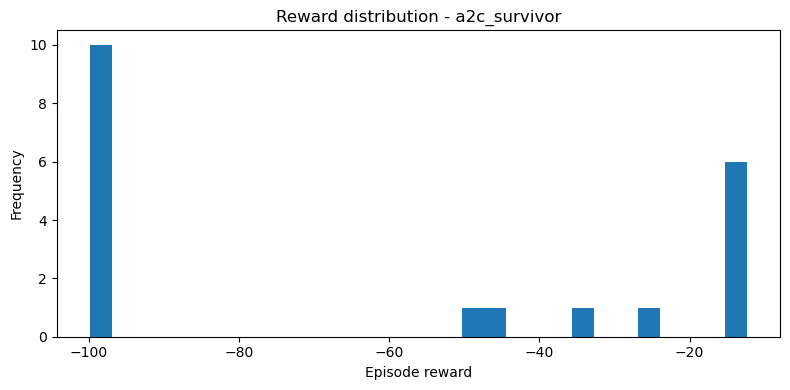

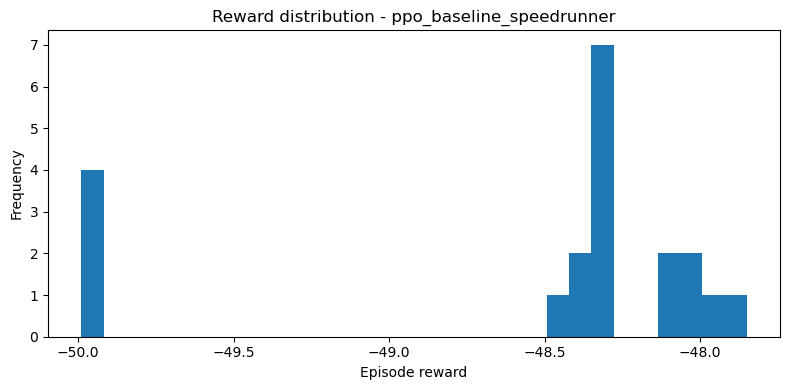

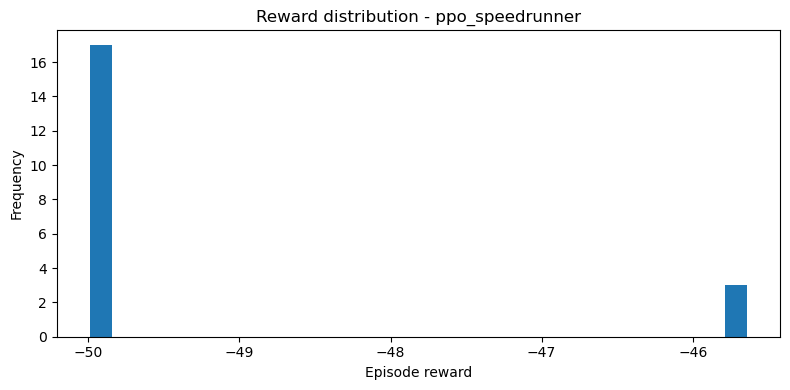

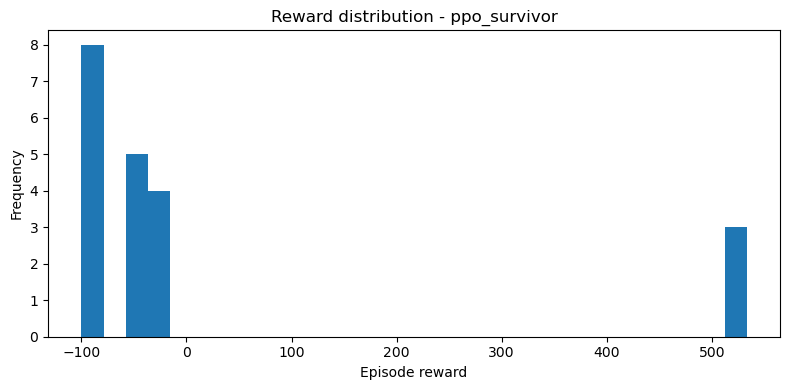

In [5]:
# Reward distributions
for name, payload in data.items():
    df = payload['per_episode']
    if 'reward' not in df.columns:
        continue
    plt.figure(figsize=(8,4))
    plt.hist(df['reward'].dropna(), bins=30)
    plt.title(f'Reward distribution - {name}')
    plt.xlabel('Episode reward')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(ANALYTICS_DIR / f'reward_hist_{name}.png')
    plt.show()

This graph displays how frequently different reward values occur across episodes.

"Survivor" Task Analysis (ppo_survivor, a2c_survivor)
This task appears to have a wide-open reward structure, likely with a large penalty for failure and a large reward for "winning" or surviving a long time.

a2c_survivor: This model is inconsistent. It has a large cluster of complete failures at a -100 reward (e.g., dying immediately). However, it also has a cluster of successful runs, with 6 episodes scoring around -15, and a few others scattered between -50 and -20.

ppo_survivor: This model shows extreme variance. It fails most of the time, with a large cluster of 17 episodes scoring between -100 and -50. However, in 3 episodes, it achieved a massively positive reward (around +520).

For the "survivor" task, both models are unstable. A2C found a consistent, moderately successful strategy (scoring -15), but it still fails half the time. PPO, on the other hand, found a largely successful solution (scoring +520) but is completely unable to execute it reliably, failing almost 90% of the time.

Speedrunner Task Analysis
The speedrunner task has a very different reward profile. All rewards are negative and tightly clustered between -50 and -45. The goal is to finish as fast as possible to get a less negative score, so getting a score of -46 is significantly better than a score of -49.

The Stable Models (a2c_speedrunner, a2c_baseline_speedrunner, ppo_baseline_speedrunner): These three models perform almost identically. They have two clear outcomes:

Failure: A cluster of episodes scoring exactly -50. This is a result of deaths occuring consistently.

Success: A large, stable cluster of episodes scoring between -48.5 and -48.0. These models have learned a consistent and reliable way to solve the level, but it is not the fastest way.

The "Optimal but Unstable" Model (ppo_speedrunner): This model is the most interesting. It fails far more often than the others, with 17 episodes (the vast majority) scoring the minimum -50 reward. However, its 3 successful runs achieved a score of approximately -45.7. This is a much better score than any of the other models, indicating it found a significantly faster, more optimal route.


Overall, PPO models (especially the non-baseline ones) seem better at exploration, finding the true optimal strategy. However, they suffer from extreme instability and haven't learned to reliably execute these strategies.

A2C and PPO Baseline models are much more stable. They found a "good enough" solution (the -48.2 speedrun route) and learned to execute it reliably, but they seem to be stuck in this suboptimal solution and are unable to find the faster route.

In [6]:
for name, payload in data.items():
    df = payload['per_episode']

    # Only proceed if the column exists and has valid data
    if 'time_to_goal' not in df.columns:
        print(f"[Skipped] No 'time_to_goal' column for {name}")
        continue

    vals = df['time_to_goal'].dropna()
    if vals.empty:
        print(f"[Skipped] 'time_to_goal' column is empty for {name}")
        continue

    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(vals, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Time-to-goal Distribution - {name}")
    plt.xlabel("Time to Goal (s)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    save_path = ANALYTICS_DI


[Skipped] 'time_to_goal' column is empty for a2c_baseline_speedrunner
[Skipped] 'time_to_goal' column is empty for a2c_speedrunner
[Skipped] 'time_to_goal' column is empty for a2c_survivor
[Skipped] 'time_to_goal' column is empty for ppo_baseline_speedrunner
[Skipped] 'time_to_goal' column is empty for ppo_speedrunner
[Skipped] 'time_to_goal' column is empty for ppo_survivor


The time to goal is empty because the agent was unable to complete the level in its testing. 

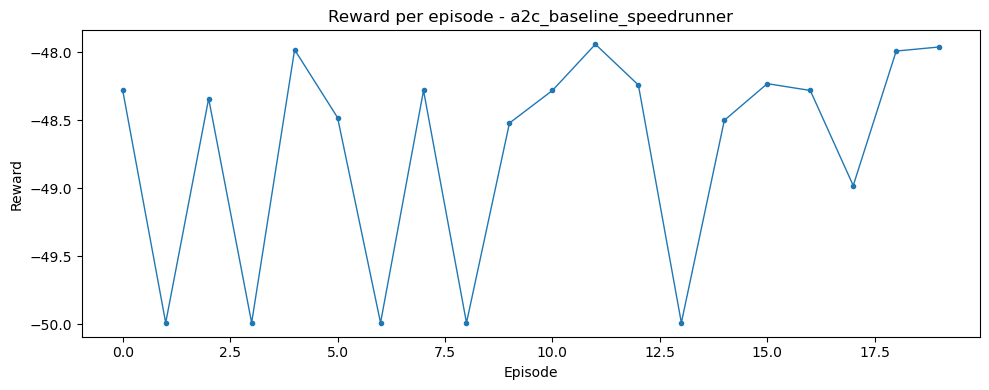

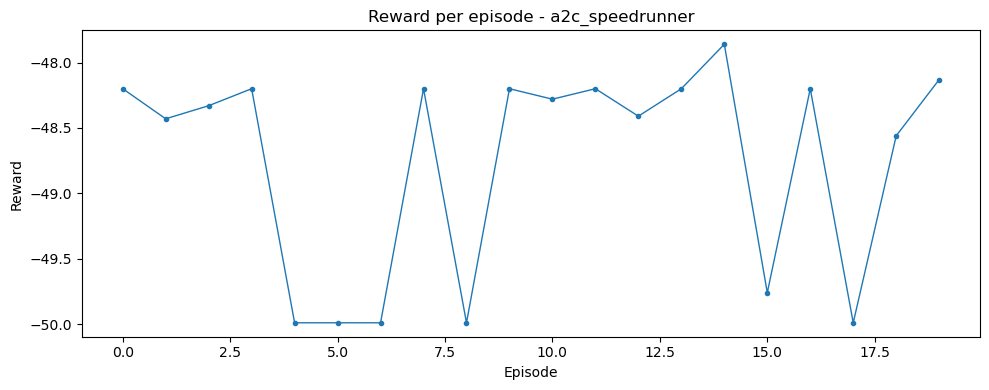

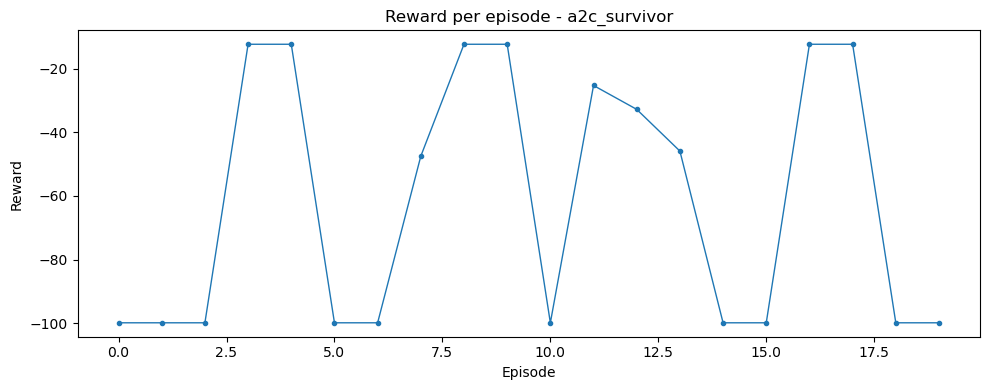

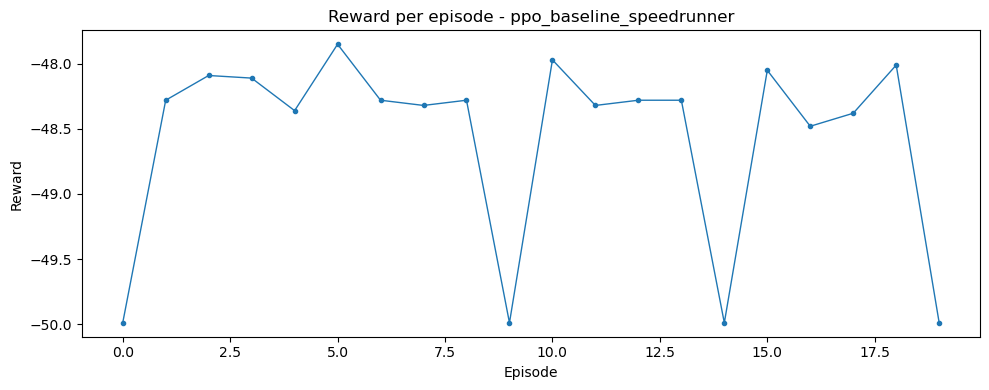

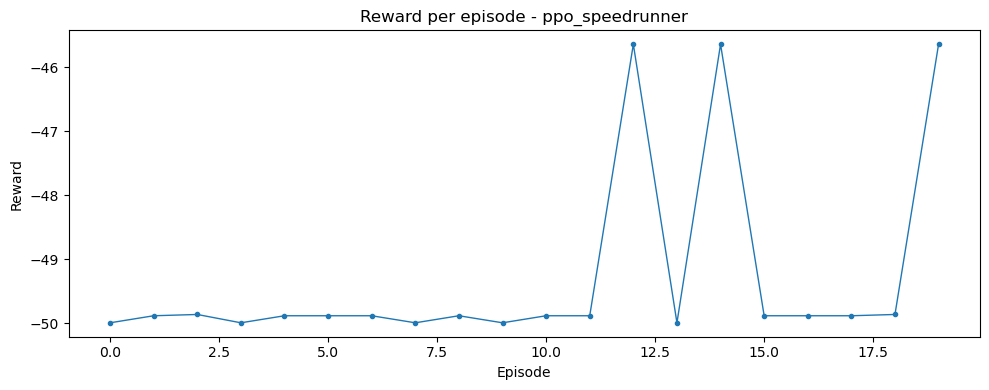

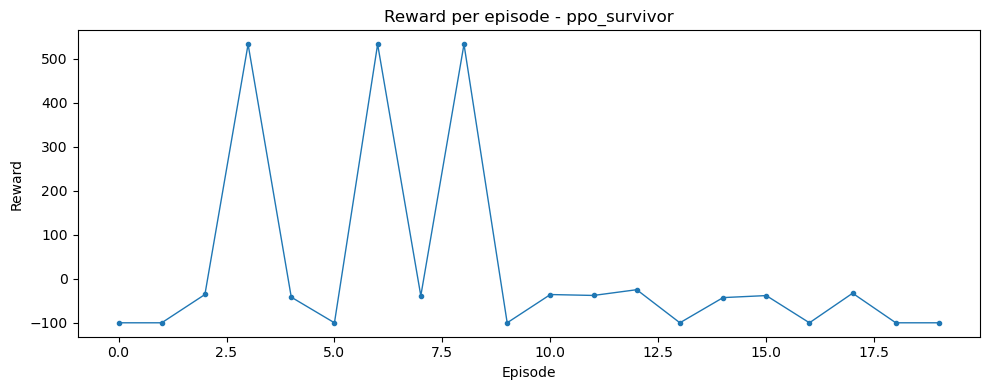

In [7]:
# Reward curves (per-episode)
for name, payload in data.items():
    df = payload['per_episode']
    if 'reward' in df.columns:
        plt.figure(figsize=(10,4))
        plt.plot(df['reward'].values, marker='.', linewidth=1)
        plt.title(f'Reward per episode - {name}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.tight_layout()
        plt.savefig(ANALYTICS_DIR / f'reward_curve_{name}.png')
        plt.show()

a2c_speedrunner, a2c_baseline_speedrunner, & ppo_baseline_speedrunner: These three models are all behaving similarly. They are highly volatile, constantly bouncing between their "good" reward (around -48) and the "failure" reward (exactly -50). This means that while they know how to execute the "good" strategy, they are not reliable and fail frequently.

ppo_speedrunner: This graph is the most dramatic. For the first 11 episodes, the agent fails every single time, flatlining at the -50 reward. Then, at episode 12, it has a sudden breakthrough and achieves the optimal score of rougly -45. It immediately fails again, then succeeds at 14, fails again, and succeeds at 19. This confirms that the agent did find the optimal route, but its strategy is exceptionally fragile. It can only execute this perfect run on rare occasions and fails constantly otherwise.

Survivor Task Analysis
The survivor models show even more extreme instability

a2c_survivor: This agent shows it can repeatedly perform well. For example, it performed well for 3 episodes in a row (2, 3, 4), scoring around -15. It did this again for episodes 7-8 and 16-17. However, it always collapses back into the -100 failure state. It has found a moderately good strategy but cannot maintain it.

ppo_survivor: This fails with a -100 reward or gets a mediocre score. However, on three rare, isolated occasions (episodes 3, 6, and 8), it hit the jackpot and achieved a massive +500 reward. This is an example of an agent finding a high-risk, high-reward strategy that almost never works but pays off when it does.

In short, these graphs show that none of the agents have converged on a stable, reliable policy.

The baseline and A2C models are stuck in an inconsistent state.

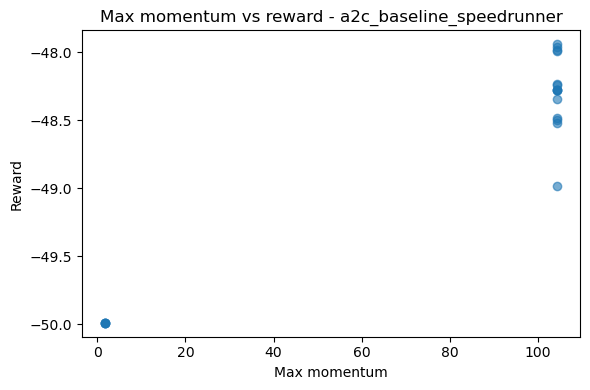

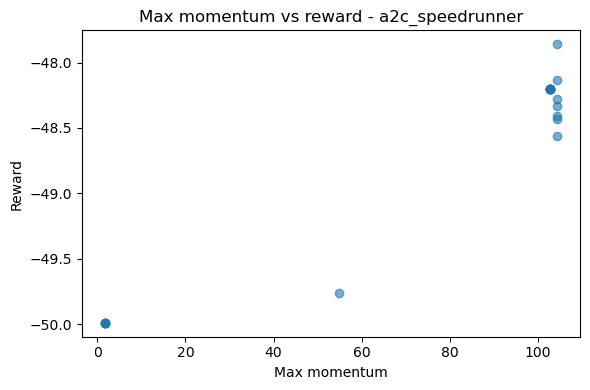

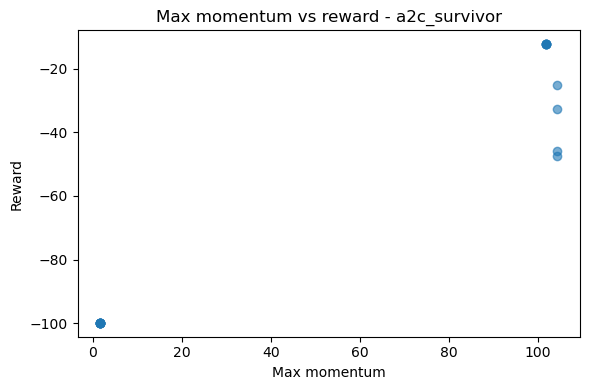

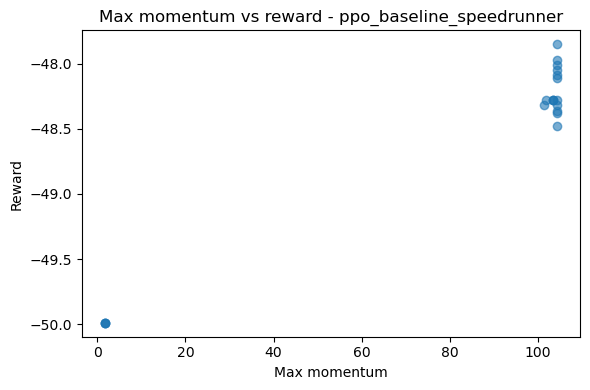

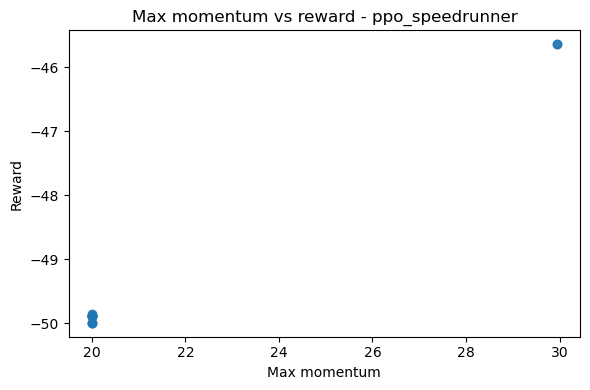

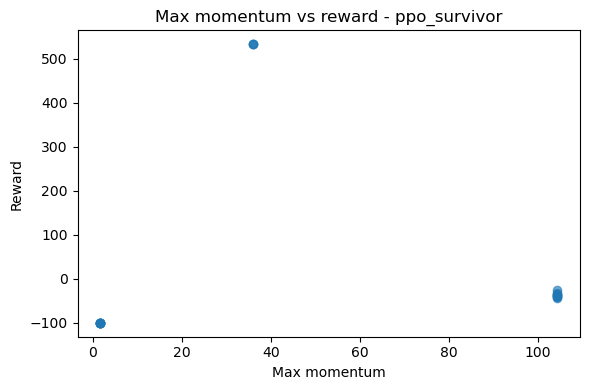

In [8]:
for name, payload in data.items():
    df = payload['per_episode']
    if 'max_momentum' in df.columns and 'reward' in df.columns:
        plt.figure(figsize=(6,4))
        plt.scatter(df['max_momentum'], df['reward'], alpha=0.6)
        plt.title(f'Max momentum vs reward - {name}')
        plt.xlabel('Max momentum')
        plt.ylabel('Reward')
        plt.tight_layout()
        plt.savefig(ANALYTICS_DIR / f'momentum_vs_reward_{name}.png')
        plt.show()

a2c_baseline_speedrunner / a2c_speedrunner / ppo_baseline_speedrunner: These three "suboptimal" models all follow the same simple logic:

Failure: If they fail to build speed (max momentum near 0-5), they fail the episode and get a -50 reward.

Success: To get their "good" reward (around -48), they must achieve a very high maximum momentum (around 100-105). Their strategy is a simple, go as fast as possible.

ppo_speedrunner: This model learned a completely different, smarter strategy:

Failure: Its failures (at -50 reward) happen at a moderate momentum of ~20.

Success: Its optimal runs (reward ~-45) are achieved with a max momentum of only ~30.

The A2C and baseline models found a route that requires going as fast as possible. The PPO model found a truly optimal route that is significantly faster (better reward) but requires less maximum speed. This implies a more precise path, a shortcut, or a technique that avoids building up and dumping momentum, making it a smarter solution.

Survivor Task Analysis::
This shows a similar fast as possible vs. smart dynamic.

a2c_survivor: This model also learned the "go fast" logic.

Failure: Dying immediately happens at near-zero momentum.

Success: All of its non-failure runs happen at a high maximum momentum of ~100. This agent's only strategy for success is to build up speed. The reward variation at high momentum suggests what it does with that speed determines its final score.

ppo_survivor: This model learned that the "go fast" strategy is actually bad, and gets a better reward when it slows down and focuses purely on attempting to beat the level.

Failure: Dying immediatelyhappens at near-zero momentum.

The cluster of -50 rewards happens at high maximum momentum (~105). This is the exact same strategy that A2C thinks is a win.

The PPO agent learned that the "go fast" strategy is not beneficial and that it leads to a poor -50 score. It discovered a completely different strategy requiring a specific moderate momentum that leads to the massive +500 win.

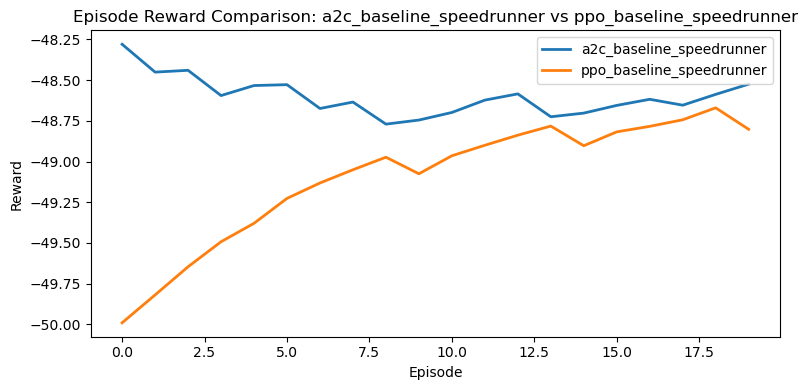

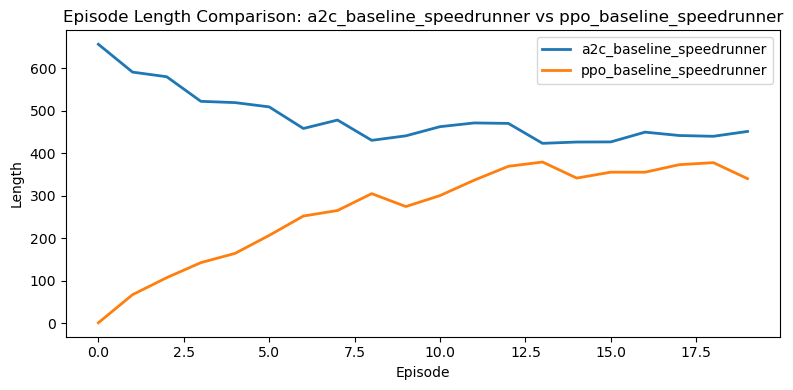

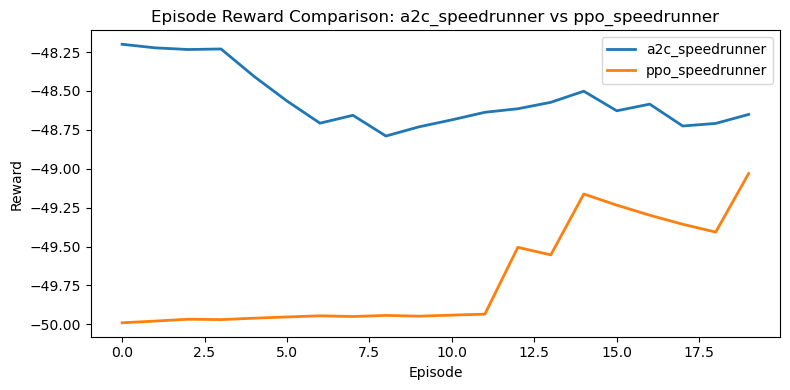

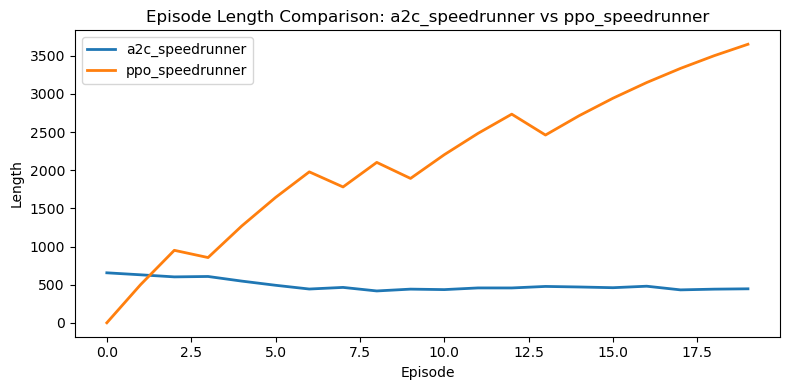

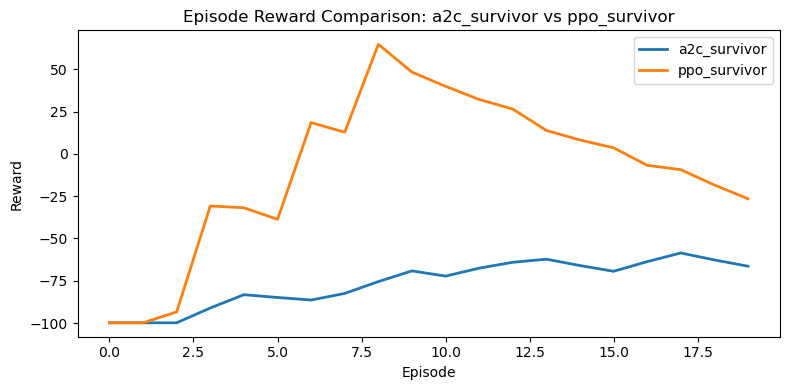

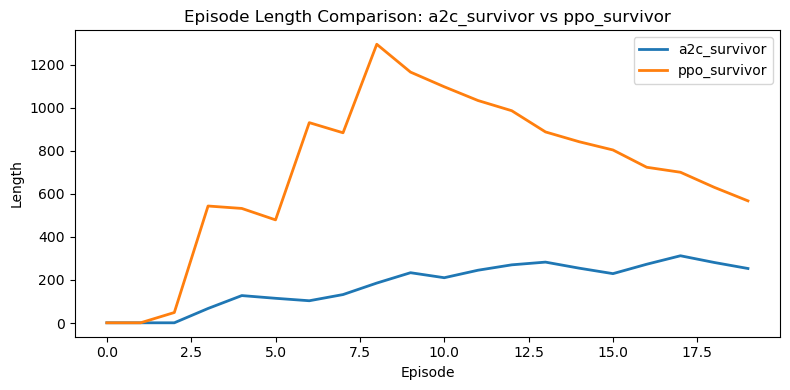

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define comparison pairs
comparison_pairs = [
    ('a2c_baseline_speedrunner', 'ppo_baseline_speedrunner'),
    ('a2c_speedrunner', 'ppo_speedrunner'),
    ('a2c_survivor', 'ppo_survivor')
]

# Helper to smooth curves
def smooth_curve(values, weight=0.9):
    smoothed = []
    last = values[0]
    for val in values:
        smoothed_val = last * weight + (1 - weight) * val
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# Generate comparison plots
for cfg1, cfg2 in comparison_pairs:
    if cfg1 not in data or cfg2 not in data:
        print(f"Skipping comparison {cfg1} vs {cfg2} — missing data.")
        continue

    df1 = data[cfg1]['per_episode']
    df2 = data[cfg2]['per_episode']

    # Episode reward comparison 
    plt.figure(figsize=(8,4))
    plt.plot(smooth_curve(df1['reward'].values), label=cfg1, linewidth=2)
    plt.plot(smooth_curve(df2['reward'].values), label=cfg2, linewidth=2)
    plt.title(f'Episode Reward Comparison: {cfg1} vs {cfg2}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Episode length comparison 
    plt.figure(figsize=(8,4))
    plt.plot(smooth_curve(df1['length'].values), label=cfg1, linewidth=2)
    plt.plot(smooth_curve(df2['length'].values), label=cfg2, linewidth=2)
    plt.title(f'Episode Length Comparison: {cfg1} vs {cfg2}')
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Time-to-goal distribution 
    if 'time_to_goal' in df1.columns and 'time_to_goal' in df2.columns:
        vals1 = df1['time_to_goal'].dropna()
        vals2 = df2['time_to_goal'].dropna()
        if not vals1.empty and not vals2.empty:
            plt.figure(figsize=(8,4))
            plt.hist(vals1, bins=30, alpha=0.6, label=cfg1)
            plt.hist(vals2, bins=30, alpha=0.6, label=cfg2)
            plt.title(f'Time-to-Goal Distribution: {cfg1} vs {cfg2}')
            plt.xlabel('Time to Goal (s)')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()
            plt.show()


Survivor Task Analysis:

Reward: The ppo_survivor's performance explodes upward around episode 3, peaking at a high positive average reward (+75). The a2c_survivor (blue) agent, in contrast, learns very slowly, never breaking out of a negative reward state.
This perfectly mirrors the reward. PPO's average episode length (survival time) shoots up to ~1300 steps, while A2C stays low ~300 steps.

PPO was vastly superior at this task. It successfully explored the environment and found the best strategy (which we saw in the scatter plot) that A2C completely missed. The eventual decline in PPO's reward and length after its peak at episode 8 confirms the instability we saw earlier.

Baseline Speedrunner Task Analysis

Reward: a2c_baseline_speedrunner learns much faster, with its average reward shooting up to the -48 range almost immediately. ppo_baseline_speedrunner learns very slowly, taking the entire training run to finally catch up to A2C's performance.

Length: A2C's episode length starts high, likely from not moving or making progress, and quickly drops to ~450 steps as it begins moving properly and learns to solve the level. PPO starts at zero (dying immediately) and slowly climbs to a similar ~400-450 step solution.

For this more straightforward task, A2C was far more efficient. It learned the optimal strategy (go fast, finish in ~450 steps) much more quickly and more stable than PPO.

Speedrunner Task Analysis (non-baseline)

Reward: A2C immediately converges to its reward of ~-48 and just stays there. PPO fails completely for 11 straight episodes, flatlining at -50 reward. It only begins to learn anything after episode 11, and its average reward never comes close to A2C's.

Length: A2C's length is stable at ~500 steps. PPO's average episode length climbs to over 3,500 steps.

In [10]:
all_rows = []
for name,payload in data.items():
    df = payload['per_episode'].copy()
    df['experiment'] = name
    df.to_csv(ANALYTICS_DIR / f'per_episode_{name}.csv', index=False)
    all_rows.append(df)
if all_rows:
    combined = pd.concat(all_rows, ignore_index=True, sort=False)
    combined.to_csv(ANALYTICS_DIR / 'per_episode_combined.csv', index=False)
    print('Saved combined per-episode CSV with', len(combined), 'rows.')
else:
    print('No per-episode data to combine.')

Saved combined per-episode CSV with 120 rows.
